In [1]:
import os, sys, json
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
if '.' not in sys.path:
    sys.path.insert(0, '.')
print("Working dir:", os.getcwd())

Working dir: c:\Users\ranje\OneDrive\Desktop\Final


In [2]:
!python evaluate.py \
    --ckpt-cls  outputs/finetune/classification/classification_best.pt \
    --ckpt-reg  outputs/finetune/regression/regression_best.pt \
    --ckpt-gen  outputs/finetune/generative/generative_best.pt \
    --ckpt-sr   outputs/finetune/superresolution/superresolution_best.pt \
    --tasks classification regression generative superresolution \
    --data-path data/jetclass_100k \
    --batch-size 256 \
    --num-workers 2 \
    --save-results outputs/eval_all_results.json

Device: cpu
Loaded train split: 80000 jets

  [train] Per-feature normalization stats:
    pT (log)        mean=+2.1190  std=1.0550
    deta            mean=-0.0011  std=0.2140
    dphi (raw)      mean=+0.0000  std=1.0000
    E (log)         mean=+2.4106  std=1.1050
  [mass]  mean=593.63 GeV  std=452.25 GeV
Loaded val split: 10000 jets
Loaded test split: 10000 jets
  Registered: FoundationLorentzParT (classification_best)
  Registered: FoundationLorentzParT (regression_best)
  Registered: FoundationLorentzParT (generative_best)
  Registered: FoundationLorentzParT (superresolution_best)

[Task: CLASSIFICATION]
  Evaluating: FoundationLorentzParT (classification_best) ... → Acc=0.4905  Top3=0.8005  F1=0.4798  AUC=0.8756
  Evaluating: FoundationLorentzParT (regression_best) ... → Acc=0.1055  Top3=0.3200  F1=0.0665  AUC=0.5142
  Evaluating: FoundationLorentzParT (generative_best) ... → Acc=0.1087  Top3=0.3355  F1=0.0514  AUC=0.5307
  Evaluating: FoundationLorentzParT (superresolution_best)

c:\Users\ranje\OneDrive\Desktop\Final\venv\Lib\site-packages\torch\utils\data\dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


In [3]:
import json
from pathlib import Path

results_path = "outputs/eval_all_results.json"
assert Path(results_path).exists(), f"Not found: {results_path}"

with open(results_path) as f:
    results = json.load(f)

print("=" * 65)
print("  FOUNDATION LORENTZPART — BENCHMARK SUMMARY")
print("  GSoC 2026 | ML4SCI / CMS | JetClass 100k")
print("=" * 65)

task_display = {
    "classification": [
        ("Accuracy",   "accuracy"),
        ("Top-3 Acc",  "top3_acc"),
        ("Macro F1",   "macro_f1"),
        ("AUC-ROC",    "auc_roc"),
    ],
    "regression": [
        ("MSE",        "mse"),
        ("MAE",        "mae"),
        ("R²",         "r2"),
        ("Resolution", "resolution"),
    ],
    "generative": [
        ("MMD",        "mmd"),
        ("pT KL Div",  "marginal_kl"),
        ("Hist MSE",   "marginal_mse"),
    ],
    "superresolution": [
        ("Chamfer",    "chamfer"),
        ("pT EMD",     "pt_emd"),
        ("Mult. Err",  "mult_err"),
    ],
}

for task, metrics in task_display.items():
    if task not in results:
        continue
    print(f"\n  [{task.upper()}]")
    for model_name, model_results in results[task].items():
        print(f"  Model: {model_name}")
        for label, key in metrics:
            val = model_results.get(key, None)
            val_str = f"{val:.4f}" if val is not None else "N/A"
            print(f"    {label:<16}: {val_str}")

print("\n" + "=" * 65)

  FOUNDATION LORENTZPART — BENCHMARK SUMMARY
  GSoC 2026 | ML4SCI / CMS | JetClass 100k

  [CLASSIFICATION]
  Model: FoundationLorentzParT (classification_best)
    Accuracy        : 0.4905
    Top-3 Acc       : 0.8005
    Macro F1        : 0.4798
    AUC-ROC         : 0.8756
  Model: FoundationLorentzParT (regression_best)
    Accuracy        : 0.1055
    Top-3 Acc       : 0.3200
    Macro F1        : 0.0665
    AUC-ROC         : 0.5142
  Model: FoundationLorentzParT (generative_best)
    Accuracy        : 0.1087
    Top-3 Acc       : 0.3355
    Macro F1        : 0.0514
    AUC-ROC         : 0.5307
  Model: FoundationLorentzParT (superresolution_best)
    Accuracy        : 0.1065
    Top-3 Acc       : 0.3268
    Macro F1        : 0.0520
    AUC-ROC         : 0.5066

  [REGRESSION]
  Model: FoundationLorentzParT (classification_best)
    MSE             : 0.8111
    MAE             : 0.7140
    R²              : 0.1928
    Resolution      : 1.1401
  Model: FoundationLorentzParT (regres

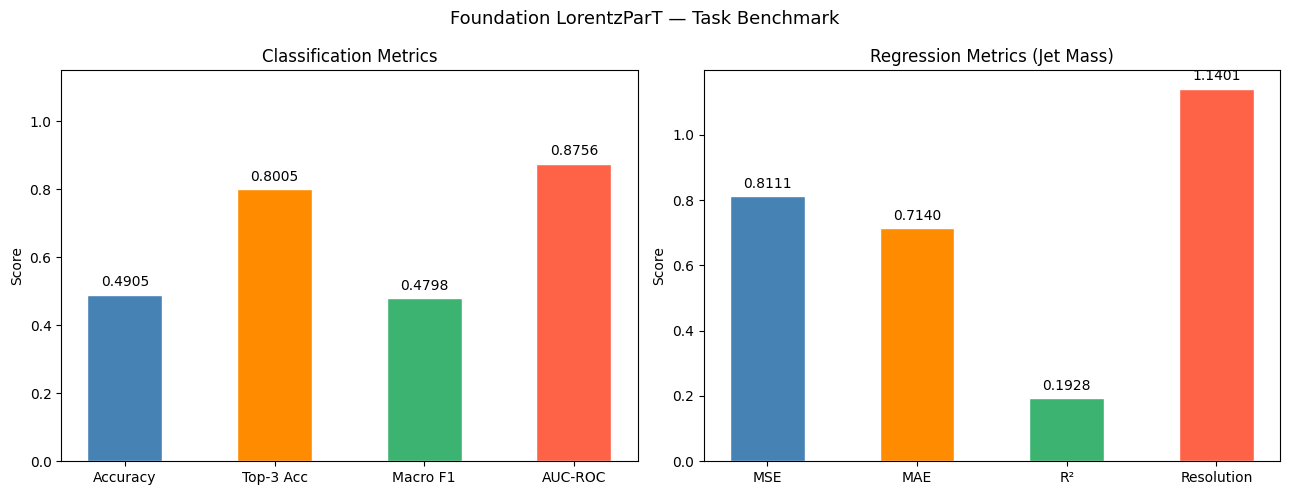

Saved → outputs/benchmark_summary.png


In [4]:
import matplotlib.pyplot as plt
import numpy as np

with open("outputs/eval_all_results.json") as f:
    results = json.load(f)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# ── Left: Classification metrics ────────────────────────────────
cls_results = results.get("classification", {})
if cls_results:
    model_name  = list(cls_results.keys())[0]
    cls_vals    = cls_results[model_name]
    metrics_cls = ["accuracy", "top3_acc", "macro_f1", "auc_roc"]
    labels_cls  = ["Accuracy", "Top-3 Acc", "Macro F1", "AUC-ROC"]
    vals_cls    = [cls_vals.get(m) or 0.0 for m in metrics_cls]

    bars = axes[0].bar(labels_cls, vals_cls,
                       color=["steelblue","darkorange","mediumseagreen","tomato"],
                       edgecolor="white", width=0.5)
    axes[0].bar_label(bars, fmt="%.4f", padding=4, fontsize=10)
    axes[0].set_ylim(0, 1.15)
    axes[0].set_ylabel("Score")
    axes[0].set_title("Classification Metrics")

# ── Right: Regression metrics ─────────────────────────────────
reg_results = results.get("regression", {})
if reg_results:
    model_name  = list(reg_results.keys())[0]
    reg_vals    = reg_results[model_name]
    metrics_reg = ["mse", "mae", "r2", "resolution"]
    labels_reg  = ["MSE", "MAE", "R²", "Resolution"]
    vals_reg    = [reg_vals.get(m) or 0.0 for m in metrics_reg]

    bars = axes[1].bar(labels_reg, vals_reg,
                       color=["steelblue","darkorange","mediumseagreen","tomato"],
                       edgecolor="white", width=0.5)
    axes[1].bar_label(bars, fmt="%.4f", padding=4, fontsize=10)
    axes[1].set_ylabel("Score")
    axes[1].set_title("Regression Metrics (Jet Mass)")

plt.suptitle("Foundation LorentzParT — Task Benchmark", fontsize=13)
plt.tight_layout()
plt.savefig("outputs/benchmark_summary.png", dpi=130, bbox_inches="tight")
plt.show()
print("Saved → outputs/benchmark_summary.png")

In [5]:
for task in ["generative", "superresolution"]:
    task_res = results.get(task, {})
    if not task_res:
        print(f"[{task}] No results found.")
        continue
    model_name = list(task_res.keys())[0]
    vals       = task_res[model_name]
    print(f"\n[{task.upper()}]")
    for k, v in vals.items():
        v_str = f"{v:.6f}" if v is not None else "N/A"
        print(f"  {k:<20}: {v_str}")


[GENERATIVE]
  mmd                 : 0.301501
  marginal_kl         : 14.143558
  marginal_mse        : 0.004045

[SUPERRESOLUTION]
  chamfer             : 0.411536
  pt_emd              : 1.622150
  mult_err            : 2.871561


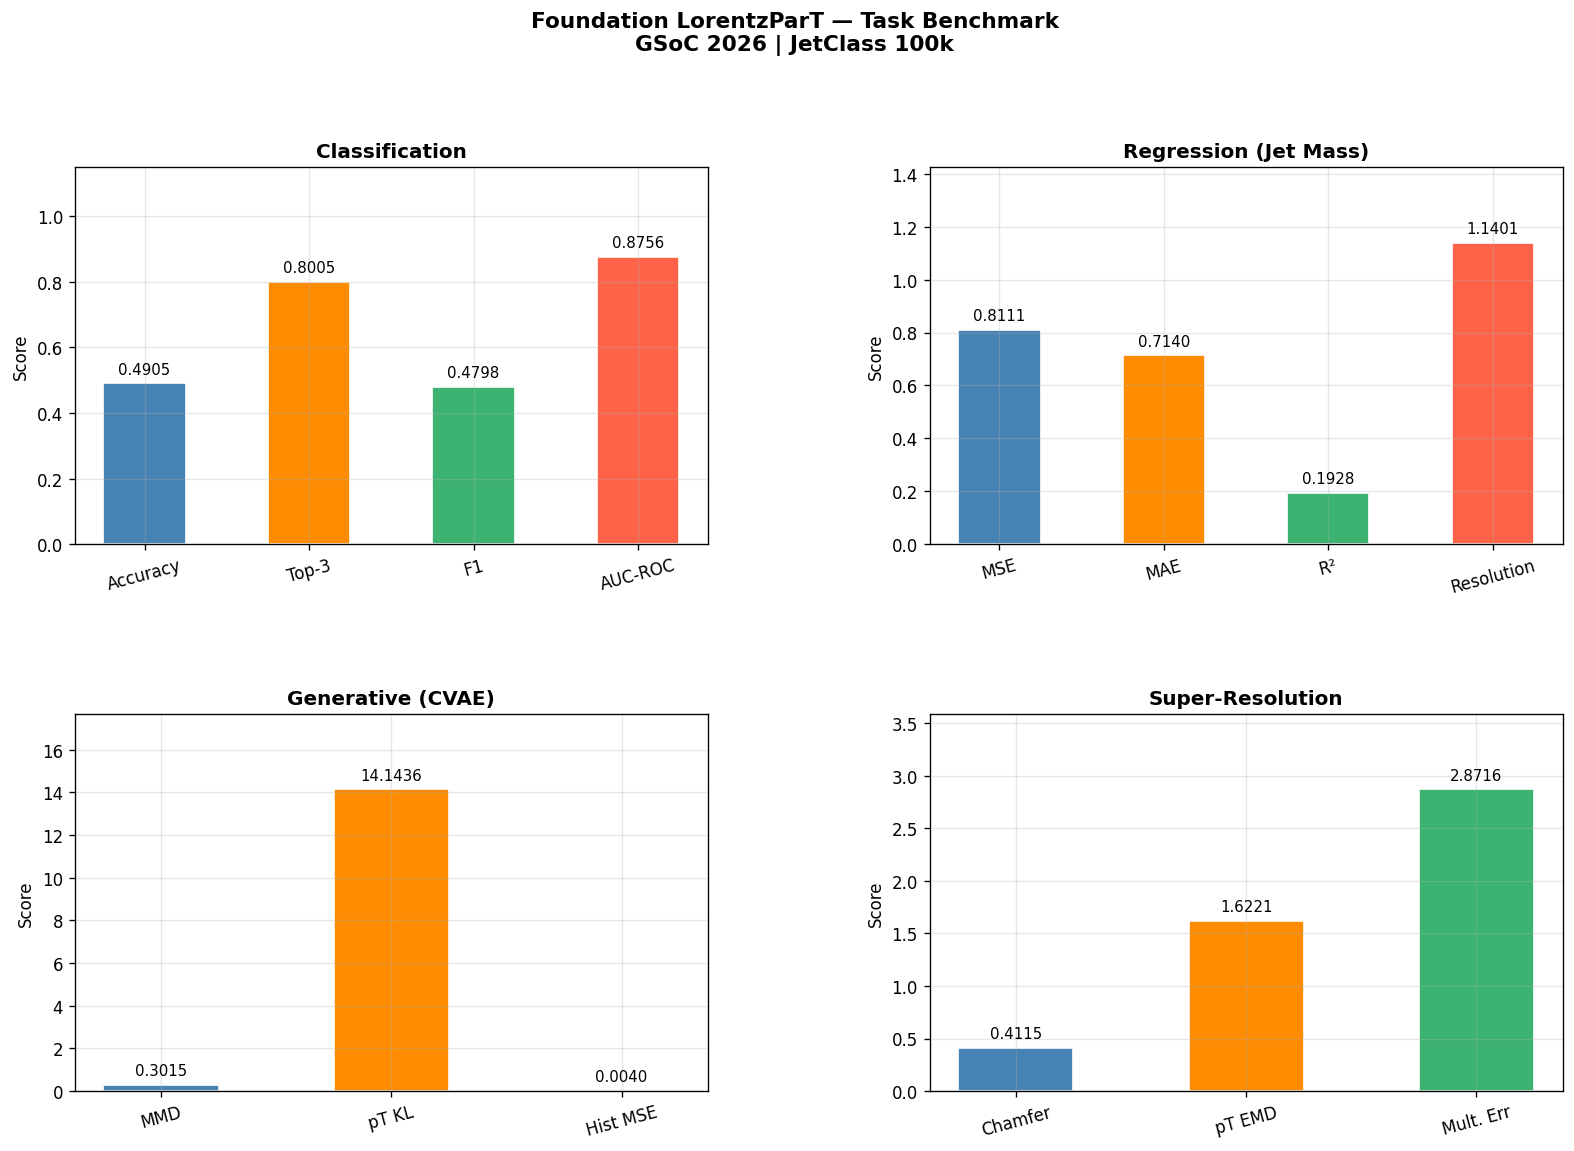

Saved → outputs/benchmark_summary_all.png


In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

plt.rcParams.update({'figure.dpi': 120, 'font.size': 10,
                     'axes.grid': True, 'grid.alpha': 0.3})

fig = plt.figure(figsize=(16, 10))
gs  = gridspec.GridSpec(2, 2, hspace=0.45, wspace=0.35)

plot_config = {
    'classification': {
        'ax'     : fig.add_subplot(gs[0, 0]),
        'metrics': [('Accuracy','accuracy'), ('Top-3','top3_acc'),
                    ('F1','macro_f1'), ('AUC-ROC','auc_roc')],
        'colors' : ['steelblue','darkorange','mediumseagreen','tomato'],
        'title'  : 'Classification',
        'ylim'   : (0, 1.15),
    },
    'regression': {
        'ax'     : fig.add_subplot(gs[0, 1]),
        'metrics': [('MSE','mse'), ('MAE','mae'),
                    ('R²','r2'), ('Resolution','resolution')],
        'colors' : ['steelblue','darkorange','mediumseagreen','tomato'],
        'title'  : 'Regression (Jet Mass)',
        'ylim'   : None,
    },
    'generative': {
        'ax'     : fig.add_subplot(gs[1, 0]),
        'metrics': [('MMD','mmd'), ('pT KL','marginal_kl'),
                    ('Hist MSE','marginal_mse')],
        'colors' : ['steelblue','darkorange','mediumseagreen'],
        'title'  : 'Generative (CVAE)',
        'ylim'   : None,
    },
    'superresolution': {
        'ax'     : fig.add_subplot(gs[1, 1]),
        'metrics': [('Chamfer','chamfer'), ('pT EMD','pt_emd'),
                    ('Mult. Err','mult_err')],
        'colors' : ['steelblue','darkorange','mediumseagreen'],
        'title'  : 'Super-Resolution',
        'ylim'   : None,
    },
}

for task, cfg in plot_config.items():
    ax = cfg['ax']

    if task not in results:
        ax.text(0.5, 0.5, 'No results', ha='center', va='center',
                transform=ax.transAxes, fontsize=12, color='gray')
        ax.set_title(cfg['title'])
        continue

    task_res   = results[task]
    model_name = list(task_res.keys())[0]
    model_vals = task_res[model_name]

    labels = [m[0] for m in cfg['metrics']]
    vals   = [model_vals.get(m[1]) or 0.0 for m in cfg['metrics']]

    bars = ax.bar(labels, vals, color=cfg['colors'],
                  edgecolor='white', width=0.5)
    ax.bar_label(bars, fmt='%.4f', padding=4, fontsize=9)

    if cfg['ylim']:
        ax.set_ylim(*cfg['ylim'])
    else:
        max_val = max(v for v in vals if v is not None)
        ax.set_ylim(0, max_val * 1.25 if max_val > 0 else 1.0)

    ax.set_title(cfg['title'], fontsize=12, fontweight='bold')
    ax.set_ylabel('Score')
    ax.tick_params(axis='x', rotation=15)

fig.suptitle(
    'Foundation LorentzParT — Task Benchmark\nGSoC 2026 | JetClass 100k',
    fontsize=13, fontweight='bold', y=1.01
)

out_png = 'outputs/benchmark_summary_all.png'
plt.savefig(out_png, dpi=130, bbox_inches='tight')
plt.show()
print(f'Saved → {out_png}')